# Setting up Parcels run (Sea urchin larval dispersal)

## Parcels run
- release in layer 1-5 
- loaction: around tenerife (depths: 0-100m) (release in box around Tenerife, exclude land cells)  
- Release times: 1 day in start_week of start_year
- 5 years runtime 
- no mortality in parcels run, done in analysis part
- output dt: 24h
## Trajectory analysis see analysis notebook

In [1]:
from parcels import (
    AdvectionRK4_3D, # including vertical velocity
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
#    AdvectionDiffusionM1,
#    DiffusionUniformKh
)
import os
from operator import attrgetter
from pathlib import Path
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
import parcels
from shapely.geometry import Polygon, Point
import cartopy
import matplotlib.pyplot as plt
from lib.release_zones import (
    csv_to_polygons_lon_lat,
    get_uniform_random_latlon_in,
    get_uniform_random_latlon_close_to_polygon,
    get_uniform_random_latlon_within_polygon,
)

print(parcels.version)

fatal: not a git repository (or any of the parent directories): .git


2.3.1


In [2]:
# parameters
RNG_seed = 123
number_particles=50000#new

#location

# release box parameters
release_depth_layer_index = 0 #5
release_layer_num = 4


# release timing
#release only in one week over 1 day 
release_time_in_days = 1
start_year = 2008 #2016
#onyl weeks(1-52)
start_week = 1

# experiment duration etc 

runtime_in_days = 180 #1st generation
dt_in_minutes =  3*60# 3h timestep 

#output
outputdt_in_hours =  24 

#forward or backward(-1)
timearrow = 1
alt_release = False

#2nd gen specific 
second_gen = True
release_zone_nr = 3 #from 1 to 4 from north to south along shelf
#scales particle number dowm by a factor determined by the area of the release box, so that over all 4 regions the particles are equally distributed
scale_part_number = True 


In [3]:
# Parameters
RNG_seed = 12345
release_zone_nr = 3
start_year = 2007
start_week = 1




# Create fieldset

In [4]:
np.random.seed(RNG_seed)


def find_i_j(lon, lat, LON, LAT):
    '''  get indices of (lon, lat) point on NEMO grid (LON,LAT)
         lon, lat: Point to get the indice
         LON, LAT: NEMO nav_lon, nav_lat '''
    a = abs(LAT - lat) + abs(LON - lon)
    j, i = np.unravel_index(a.argmin(), a.shape)
    return (i, j)

#load input data
#get indices 

mask_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/")
mesh_mask_filename = '1_mesh_mask.nc'

mesh_mask = mask_path / mesh_mask_filename

mesh_hgr = xr.open_dataset(mesh_mask)
mesh_hgr = mesh_hgr.squeeze()
glon = mesh_hgr.glamt  # Note: T grid is the definition.  All others derived.
glat = mesh_hgr.gphit

#window
lattop=40
latbottom=-20
lonleft=-50
lonright=15

i_left, j_bottom = find_i_j(lonleft, latbottom, glon, glat)
i_right, j_top = find_i_j(lonright, lattop, glon, glat)


sd_i1, sd_i2 = i_left, i_right  # western/eastern limit (indices not coordinates)
sd_j1, sd_j2 = j_bottom, j_top  # southern/northern limit (indices not coordinates)

sd_z1, sd_z2 = 0 , 14 #vertical limits indices (first 160 m , 15 levels)
                       

x_window=slice(i_left, i_right)
y_window=slice(j_bottom, j_top)


mesh_mask = mask_path / mesh_mask_filename
#mask still has time dependency (save with .squeeze() in own directoy? )


#input data filename
experiment_name = "VIKING20X.L46-KFS003"
data_resolution = "1d"

#data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-2nd/nemo/output/"
data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/"
data_path_w = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/derived/1d_compressed"

years_run = np.arange(int(runtime_in_days / 365)) + start_year # all years needed for run

if timearrow == -1:
    years_run = np.sort(-np.arange(int(runtime_in_days / 365)) + start_year)# all years needed for run
    
    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_W.nc'))

else:

    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_W.nc'))


#for multiple consecutive years after stating year
for year in years_run[1:]:
    file_U = f'1_{experiment_name}_{data_resolution}_{year}*_grid_U.nc'
    file_V = f'1_{experiment_name}_{data_resolution}_{year}*_grid_V.nc' 
    file_W = f'1_{experiment_name}_{data_resolution}_{year}*_grid_W.nc' 
    
    files_U_list.append(list(Path(data_path).glob(file_U))[0])
    files_V_list.append(list(Path(data_path).glob(file_V))[0]) 
    files_W_list.append(list(Path(data_path_w).glob(file_W))[0])
    #T_list

#choose release depths from layers of VIKING grid 
layer_depths = [3.046773,9.454049,16.363966,23.89871,  32.20929 ,  
                 41.481853, 51.94513 ,  63.87905 ,  77.62451 ,  93.594124]# upper 10 layers
depth_min = layer_depths[release_depth_layer_index]
depth_max = layer_depths[release_depth_layer_index + release_layer_num]
    
    
#sorted(Path(data_path).glob(data_filename))
outpath = '../output_data/second_gen/'
output_filename = f'urchin_2ndgen_zone{release_zone_nr}_{start_year:04d}_w{start_week:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'


if timearrow == -1:
    output_filename = 'backtrack_' + output_filename
    
output_filename

'urchin_2ndgen_zone3_2007_w01_RT-180_N-50000_seed-12345.nc'

In [5]:
def fieldset_defintions(
    list_of_filenames_U, 
    list_of_filenames_V,
    list_of_filenames_W, 
#    list_of_filenames_T,
    mesh_mask
):
#    print(list_of_filenames_W)
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0], #??
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
#                 'T': {'lon': (mesh_mask),
#                       'lat': (mesh_mask),
#                       'depth': list_of_filenames_T[0],
#                       'data': list_of_filenames_T}
                }
    
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
#                 'T': 'votemper'
                }
        
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
#                  'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht',
#                        'time': 'time_counter'},  # needs to be on t-nodes
                 }
    
    indices = {
        'U': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'V': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'W': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
#        'T': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2)}, 'lat':range(sd_j1, sd_j2)
    }    

    return FieldSet.from_nemo(
        filenames, variables, dimensions, indices=indices,
        #field_chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )


 # Create Fieldset

In [6]:
fieldset = fieldset_defintions(
        files_U_list, files_V_list,
        files_W_list, #files_T,
        mesh_mask)

# Create particleset

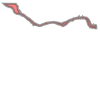

In [7]:
#standart release zone around tenerife
data_path = '/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/' 

exterior = pd.read_csv(Path(data_path + 'release_zone_exterior500.csv')).values.tolist()
interior = pd.read_csv(Path(data_path + 'release_zone_interior.csv')).values.tolist()
box_poly = Polygon(exterior, [interior])

#override for wlternative release zones
if second_gen:
    zone_list = ['release_zone_shelf_30N_20N.csv', 'release_zone_shelf_20N_10N.csv', 
        'release_zone_shelf_10N_7E.csv','release_zone_shelf_7E_10S.csv']
    
    #to release 
    

    
    
    exterior = pd.read_csv(Path(data_path + zone_list[release_zone_nr-1])).values.tolist()
    box_poly = Polygon(exterior, [])
#create inuform particle disstr in polygon (from northsea oysters?)


box_poly

In [8]:
#scale üaricel number
if scale_part_number:
    
    factor_list = [0.25251346443841644, 0.3534648993158345, 0.17045281458435538, 0.2235688216613935]
    number_particles = int(number_particles*factor_list[release_zone_nr-1])
    
number_particles

8522

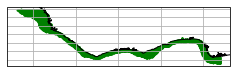

In [9]:
#generate lat lon values inside the polygon
in_poly = get_uniform_random_latlon_within_polygon(box_poly,N = number_particles, max_iter=40)


fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    figsize=(4, 4),
)

#ax.plot(box_poly.exterior.xy, transform=cartopy.crs.PlateCarree(), linewidth=1, color="blue")
in_poly.astype(float).plot.scatter(
        x="lon", y="lat", s=1, c="green",
        ax=ax, transform=cartopy.crs.PlateCarree()
        )

ax.coastlines()
ax.gridlines()

In [10]:
#random release time in time window (1st day of release week)
rel_time  = np.sort(
   dt.datetime.fromisocalendar(start_year, start_week,1)
    + dt.timedelta(minutes=dt_in_minutes) * np.random.randint(
        0,
        dt.timedelta(days=release_time_in_days) / dt.timedelta(minutes=dt_in_minutes),
        size=(number_particles, )
    )
)

#calc correct runtime
corr_runtime_in_days = runtime_in_days + release_time_in_days

depth = np.random.uniform(
    depth_min,
    depth_max, #lower boundary of box
    size=rel_time.shape
)


pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lat=in_poly.lat.values,
    lon=in_poly.lon.values,
    depth=depth,
    time=rel_time
) 
print(f"Created {len(pset)} particles.")

Created 8522 particles.


In [11]:
#Kernels and error handling

def DeleteParticle(particle, fieldset, time): 
    particle.delete()

recovery_cases = {
    ErrorCode.ErrorOutOfBounds: DeleteParticle
}

# config kernel here

custom_kernel = pset.Kernel(AdvectionRK4_3D)


In [12]:
#prepare Output
output_filenamepath = outpath + output_filename
print(output_filenamepath)

outputfile = pset.ParticleFile(
    name=output_filenamepath,
    outputdt=dt.timedelta(hours=outputdt_in_hours)
)

../output_data/second_gen/urchin_2ndgen_zone3_2007_w01_RT-180_N-50000_seed-12345.nc


In [13]:
%%time
#execute
pset.execute(
    custom_kernel,
    runtime=dt.timedelta(days=corr_runtime_in_days),
    dt=dt.timedelta(minutes=dt_in_minutes * timearrow),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
    output_file=outputfile,
)

outputfile.export()

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-729666/lib828b29ebcdcad61cd95c81c30bc3afb7_0.so


INFO: Temporary output files are stored in ../output_data/second_gen/out-RTCUKSIL.


INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/second_gen/out-RTCUKSIL" to convert these to a NetCDF file during the run.


  0%|          | 0/15638400.0 [00:00<?, ?it/s]

  2%|▏         | 259200.0/15638400.0 [00:00<00:19, 792348.25it/s]

  2%|▏         | 345600.0/15638400.0 [00:05<04:55, 51718.92it/s] 

  2%|▏         | 388800.0/15638400.0 [00:10<09:19, 27278.10it/s]

  3%|▎         | 432000.0/15638400.0 [00:10<07:42, 32882.85it/s]

  3%|▎         | 475200.0/15638400.0 [00:15<12:25, 20329.24it/s]

  3%|▎         | 518400.0/15638400.0 [00:15<09:45, 25838.62it/s]

  4%|▎         | 561600.0/15638400.0 [00:20<14:26, 17393.84it/s]

  4%|▍         | 604800.0/15638400.0 [00:20<10:57, 22871.81it/s]

  4%|▍         | 648000.0/15638400.0 [00:25<15:48, 15806.25it/s]

  4%|▍         | 691200.0/15638400.0 [00:25<11:45, 21190.25it/s]

  5%|▍         | 734400.0/15638400.0 [00:30<16:22, 15173.73it/s]

  5%|▍         | 777600.0/15638400.0 [00:30<12:03, 20541.43it/s]

  5%|▌         | 820800.0/15638400.0 [00:35<16:39, 14829.18it/s]

  6%|▌         | 864000.0/15638400.0 [00:36<12:11, 20200.42it/s]

  6%|▌         | 907200.0/15638400.0 [00:40<16:25, 14948.58it/s]

  6%|▌         | 950400.0/15638400.0 [00:41<12:00, 20393.93it/s]

  6%|▋         | 993600.0/15638400.0 [00:45<16:21, 14923.90it/s]

  7%|▋         | 1036800.0/15638400.0 [00:46<11:56, 20389.52it/s]

  7%|▋         | 1080000.0/15638400.0 [00:50<16:20, 14840.37it/s]

  7%|▋         | 1123200.0/15638400.0 [00:51<11:55, 20288.38it/s]

  7%|▋         | 1166400.0/15638400.0 [00:55<16:17, 14804.53it/s]

  8%|▊         | 1209600.0/15638400.0 [00:56<11:52, 20253.47it/s]

  8%|▊         | 1252800.0/15638400.0 [01:00<15:57, 15030.04it/s]

  8%|▊         | 1296000.0/15638400.0 [01:01<11:37, 20549.36it/s]

  9%|▊         | 1339200.0/15638400.0 [01:05<16:11, 14716.84it/s]

  9%|▉         | 1382400.0/15638400.0 [01:06<11:48, 20134.74it/s]

  9%|▉         | 1425600.0/15638400.0 [01:11<15:59, 14815.96it/s]

  9%|▉         | 1468800.0/15638400.0 [01:11<11:39, 20261.01it/s]

 10%|▉         | 1512000.0/15638400.0 [01:16<15:55, 14791.90it/s]

 10%|▉         | 1555200.0/15638400.0 [01:16<11:35, 20238.52it/s]

 10%|█         | 1598400.0/15638400.0 [01:21<15:47, 14814.61it/s]

 10%|█         | 1641600.0/15638400.0 [01:21<11:30, 20263.79it/s]

 11%|█         | 1684800.0/15638400.0 [01:26<15:43, 14784.31it/s]

 11%|█         | 1728000.0/15638400.0 [01:26<11:27, 20223.46it/s]

 11%|█▏        | 1771200.0/15638400.0 [01:31<15:59, 14452.46it/s]

 12%|█▏        | 1814400.0/15638400.0 [01:31<11:38, 19789.23it/s]

 12%|█▏        | 1857600.0/15638400.0 [01:36<15:56, 14405.38it/s]

 12%|█▏        | 1900800.0/15638400.0 [01:36<11:36, 19727.11it/s]

 12%|█▏        | 1944000.0/15638400.0 [01:41<15:40, 14567.05it/s]

 13%|█▎        | 1987200.0/15638400.0 [01:42<11:25, 19922.14it/s]

 13%|█▎        | 2030400.0/15638400.0 [01:47<15:55, 14234.70it/s]

 13%|█▎        | 2073600.0/15638400.0 [01:47<11:35, 19499.26it/s]

 14%|█▎        | 2116800.0/15638400.0 [01:52<15:47, 14275.05it/s]

 14%|█▍        | 2160000.0/15638400.0 [01:52<11:29, 19552.82it/s]

 14%|█▍        | 2203200.0/15638400.0 [01:57<15:39, 14303.39it/s]

 14%|█▍        | 2246400.0/15638400.0 [01:57<11:23, 19593.31it/s]

 15%|█▍        | 2289600.0/15638400.0 [02:02<15:10, 14665.50it/s]

 15%|█▍        | 2332800.0/15638400.0 [02:02<11:03, 20061.18it/s]

 15%|█▌        | 2376000.0/15638400.0 [02:07<14:54, 14825.44it/s]

 15%|█▌        | 2419200.0/15638400.0 [02:07<10:51, 20277.49it/s]

 16%|█▌        | 2462400.0/15638400.0 [02:12<14:50, 14788.56it/s]

 16%|█▌        | 2505600.0/15638400.0 [02:12<10:49, 20219.06it/s]

 16%|█▋        | 2548800.0/15638400.0 [02:17<14:37, 14917.49it/s]

 17%|█▋        | 2592000.0/15638400.0 [02:17<10:39, 20397.92it/s]

 17%|█▋        | 2635200.0/15638400.0 [02:22<14:19, 15135.30it/s]

 17%|█▋        | 2678400.0/15638400.0 [02:22<10:26, 20676.80it/s]

 17%|█▋        | 2721600.0/15638400.0 [02:27<13:57, 15430.75it/s]

 18%|█▊        | 2764800.0/15638400.0 [02:27<10:10, 21069.87it/s]

 18%|█▊        | 2808000.0/15638400.0 [02:32<14:11, 15069.37it/s]

 18%|█▊        | 2851200.0/15638400.0 [02:32<10:21, 20590.17it/s]

 19%|█▊        | 2894400.0/15638400.0 [02:37<14:08, 15013.33it/s]

 19%|█▉        | 2937600.0/15638400.0 [02:37<10:18, 20528.77it/s]

 19%|█▉        | 2980800.0/15638400.0 [02:42<14:27, 14582.84it/s]

 19%|█▉        | 3024000.0/15638400.0 [02:42<10:32, 19951.67it/s]

 20%|█▉        | 3067200.0/15638400.0 [02:47<14:26, 14514.63it/s]

 20%|█▉        | 3110400.0/15638400.0 [02:48<10:30, 19864.30it/s]

 20%|██        | 3153600.0/15638400.0 [02:52<14:18, 14545.48it/s]

 20%|██        | 3196800.0/15638400.0 [02:53<10:25, 19902.24it/s]

 21%|██        | 3240000.0/15638400.0 [02:58<14:30, 14245.27it/s]

 21%|██        | 3283200.0/15638400.0 [02:58<10:33, 19517.36it/s]

 21%|██▏       | 3326400.0/15638400.0 [03:03<14:06, 14547.18it/s]

 22%|██▏       | 3369600.0/15638400.0 [03:03<10:16, 19911.06it/s]

 22%|██▏       | 3412800.0/15638400.0 [03:08<13:52, 14677.85it/s]

 22%|██▏       | 3456000.0/15638400.0 [03:08<10:06, 20084.66it/s]

 22%|██▏       | 3499200.0/15638400.0 [03:13<13:52, 14583.51it/s]

 23%|██▎       | 3542400.0/15638400.0 [03:13<10:06, 19945.11it/s]

 23%|██▎       | 3585600.0/15638400.0 [03:18<14:08, 14205.72it/s]

 23%|██▎       | 3628800.0/15638400.0 [03:19<10:17, 19455.27it/s]

 23%|██▎       | 3672000.0/15638400.0 [03:23<13:48, 14443.06it/s]

 24%|██▍       | 3715200.0/15638400.0 [03:24<10:03, 19769.91it/s]

 24%|██▍       | 3758400.0/15638400.0 [03:29<13:44, 14405.72it/s]

 24%|██▍       | 3801600.0/15638400.0 [03:29<10:00, 19725.14it/s]

 25%|██▍       | 3844800.0/15638400.0 [03:34<13:39, 14388.79it/s]

 25%|██▍       | 3888000.0/15638400.0 [03:34<09:56, 19704.21it/s]

 25%|██▌       | 3931200.0/15638400.0 [03:39<13:35, 14359.26it/s]

 25%|██▌       | 3974400.0/15638400.0 [03:39<09:53, 19659.18it/s]

 26%|██▌       | 4017600.0/15638400.0 [03:44<13:44, 14101.69it/s]

 26%|██▌       | 4060800.0/15638400.0 [03:45<09:59, 19313.35it/s]

 26%|██▌       | 4104000.0/15638400.0 [03:50<13:26, 14308.22it/s]

 27%|██▋       | 4147200.0/15638400.0 [03:50<09:46, 19588.39it/s]

 27%|██▋       | 4190400.0/15638400.0 [03:55<13:02, 14621.08it/s]

 27%|██▋       | 4233600.0/15638400.0 [03:55<09:30, 20004.02it/s]

 27%|██▋       | 4276800.0/15638400.0 [04:00<12:59, 14579.26it/s]

 28%|██▊       | 4320000.0/15638400.0 [04:00<09:27, 19947.98it/s]

 28%|██▊       | 4363200.0/15638400.0 [04:05<12:59, 14466.80it/s]

 28%|██▊       | 4406400.0/15638400.0 [04:05<09:26, 19812.18it/s]

 28%|██▊       | 4449600.0/15638400.0 [04:10<13:22, 13947.50it/s]

 29%|██▊       | 4492800.0/15638400.0 [04:11<09:42, 19124.23it/s]

 29%|██▉       | 4536000.0/15638400.0 [04:16<12:56, 14306.77it/s]

 29%|██▉       | 4579200.0/15638400.0 [04:16<09:24, 19582.02it/s]

 30%|██▉       | 4622400.0/15638400.0 [04:21<12:29, 14701.82it/s]

 30%|██▉       | 4665600.0/15638400.0 [04:21<09:05, 20115.18it/s]

 30%|███       | 4708800.0/15638400.0 [04:26<12:24, 14679.21it/s]

 30%|███       | 4752000.0/15638400.0 [04:26<09:02, 20084.87it/s]

 31%|███       | 4795200.0/15638400.0 [04:31<12:14, 14768.39it/s]

 31%|███       | 4838400.0/15638400.0 [04:31<08:54, 20201.12it/s]

 31%|███       | 4881600.0/15638400.0 [04:36<12:13, 14667.89it/s]

 31%|███▏      | 4924800.0/15638400.0 [04:36<08:53, 20067.26it/s]

 32%|███▏      | 4968000.0/15638400.0 [04:41<12:17, 14468.75it/s]

 32%|███▏      | 5011200.0/15638400.0 [04:41<08:56, 19806.88it/s]

 32%|███▏      | 5054400.0/15638400.0 [04:46<12:06, 14573.16it/s]

 33%|███▎      | 5097600.0/15638400.0 [04:46<08:48, 19926.86it/s]

 33%|███▎      | 5140800.0/15638400.0 [04:51<11:58, 14612.59it/s]

 33%|███▎      | 5184000.0/15638400.0 [04:52<08:43, 19986.82it/s]

 33%|███▎      | 5227200.0/15638400.0 [04:56<11:58, 14482.88it/s]

 34%|███▎      | 5270400.0/15638400.0 [04:57<08:43, 19820.30it/s]

 34%|███▍      | 5313600.0/15638400.0 [05:02<11:46, 14610.03it/s]

 34%|███▍      | 5356800.0/15638400.0 [05:02<08:34, 19987.29it/s]

 35%|███▍      | 5400000.0/15638400.0 [05:06<11:27, 14899.66it/s]

 35%|███▍      | 5443200.0/15638400.0 [05:07<08:20, 20366.52it/s]

 35%|███▌      | 5486400.0/15638400.0 [05:11<11:13, 15077.34it/s]

 35%|███▌      | 5529600.0/15638400.0 [05:12<08:10, 20598.62it/s]

 36%|███▌      | 5572800.0/15638400.0 [05:16<10:51, 15438.35it/s]

 36%|███▌      | 5616000.0/15638400.0 [05:16<07:55, 21061.82it/s]

 36%|███▌      | 5659200.0/15638400.0 [05:21<11:11, 14850.57it/s]

 36%|███▋      | 5702400.0/15638400.0 [05:22<08:09, 20297.44it/s]

 37%|███▋      | 5745600.0/15638400.0 [05:26<11:07, 14830.62it/s]

 37%|███▋      | 5788800.0/15638400.0 [05:27<08:06, 20265.08it/s]

 37%|███▋      | 5832000.0/15638400.0 [05:31<10:56, 14936.54it/s]

 38%|███▊      | 5875200.0/15638400.0 [05:32<07:58, 20404.17it/s]

 38%|███▊      | 5918400.0/15638400.0 [05:36<10:40, 15179.87it/s]

 38%|███▊      | 5961600.0/15638400.0 [05:36<07:46, 20732.50it/s]

 38%|███▊      | 6004800.0/15638400.0 [05:41<10:23, 15448.14it/s]

 39%|███▊      | 6048000.0/15638400.0 [05:41<07:34, 21087.78it/s]

 39%|███▉      | 6091200.0/15638400.0 [05:46<10:39, 14936.19it/s]

 39%|███▉      | 6134400.0/15638400.0 [05:46<07:45, 20416.88it/s]

 40%|███▉      | 6177600.0/15638400.0 [05:51<10:37, 14833.41it/s]

 40%|███▉      | 6220800.0/15638400.0 [05:51<07:44, 20283.71it/s]

 40%|████      | 6264000.0/15638400.0 [05:56<10:39, 14657.49it/s]

 40%|████      | 6307200.0/15638400.0 [05:57<07:45, 20054.39it/s]

 41%|████      | 6350400.0/15638400.0 [06:01<10:30, 14736.83it/s]

 41%|████      | 6393600.0/15638400.0 [06:02<07:38, 20159.41it/s]

 41%|████      | 6436800.0/15638400.0 [06:07<10:36, 14462.25it/s]

 41%|████▏     | 6480000.0/15638400.0 [06:07<07:42, 19800.04it/s]

 42%|████▏     | 6523200.0/15638400.0 [06:12<10:20, 14683.61it/s]

 42%|████▏     | 6566400.0/15638400.0 [06:12<07:31, 20089.09it/s]

 42%|████▏     | 6609600.0/15638400.0 [06:17<10:14, 14687.21it/s]

 43%|████▎     | 6652800.0/15638400.0 [06:17<07:27, 20063.55it/s]

 43%|████▎     | 6696000.0/15638400.0 [06:22<10:20, 14407.86it/s]

 43%|████▎     | 6739200.0/15638400.0 [06:22<07:31, 19727.27it/s]

 43%|████▎     | 6782400.0/15638400.0 [06:27<10:07, 14587.83it/s]

 44%|████▎     | 6825600.0/15638400.0 [06:27<07:21, 19953.80it/s]

 44%|████▍     | 6868800.0/15638400.0 [06:32<09:59, 14623.38it/s]

 44%|████▍     | 6912000.0/15638400.0 [06:33<07:16, 20005.77it/s]

 44%|████▍     | 6955200.0/15638400.0 [06:37<09:54, 14605.95it/s]

 45%|████▍     | 6998400.0/15638400.0 [06:38<07:12, 19982.55it/s]

 45%|████▌     | 7041600.0/15638400.0 [06:42<09:45, 14685.94it/s]

 45%|████▌     | 7084800.0/15638400.0 [06:43<07:05, 20091.82it/s]

 46%|████▌     | 7128000.0/15638400.0 [06:48<09:41, 14638.92it/s]

 46%|████▌     | 7171200.0/15638400.0 [06:48<07:03, 20011.94it/s]

 46%|████▌     | 7214400.0/15638400.0 [06:52<09:25, 14896.09it/s]

 46%|████▋     | 7257600.0/15638400.0 [06:53<06:51, 20367.11it/s]

 47%|████▋     | 7300800.0/15638400.0 [06:57<09:19, 14902.92it/s]

 47%|████▋     | 7344000.0/15638400.0 [06:58<06:47, 20377.50it/s]

 47%|████▋     | 7387200.0/15638400.0 [07:03<09:23, 14641.44it/s]

 48%|████▊     | 7430400.0/15638400.0 [07:03<06:49, 20032.74it/s]

 48%|████▊     | 7473600.0/15638400.0 [07:08<09:18, 14607.80it/s]

 48%|████▊     | 7516800.0/15638400.0 [07:08<06:46, 19979.79it/s]

 48%|████▊     | 7560000.0/15638400.0 [07:13<09:15, 14530.16it/s]

 49%|████▊     | 7603200.0/15638400.0 [07:13<06:43, 19891.54it/s]

 49%|████▉     | 7646400.0/15638400.0 [07:18<09:13, 14432.74it/s]

 49%|████▉     | 7689600.0/15638400.0 [07:18<06:42, 19741.22it/s]

 49%|████▉     | 7732800.0/15638400.0 [07:23<09:04, 14512.71it/s]

 50%|████▉     | 7776000.0/15638400.0 [07:24<06:35, 19861.04it/s]

 50%|█████     | 7819200.0/15638400.0 [07:28<08:49, 14755.05it/s]

 50%|█████     | 7862400.0/15638400.0 [07:29<06:25, 20183.10it/s]

 51%|█████     | 7905600.0/15638400.0 [07:33<08:36, 14983.46it/s]

 51%|█████     | 7948800.0/15638400.0 [07:34<06:15, 20472.32it/s]

 51%|█████     | 7992000.0/15638400.0 [07:38<08:38, 14758.52it/s]

 51%|█████▏    | 8035200.0/15638400.0 [07:39<06:16, 20183.74it/s]

 52%|█████▏    | 8078400.0/15638400.0 [07:43<08:31, 14768.24it/s]

 52%|█████▏    | 8121600.0/15638400.0 [07:44<06:12, 20185.97it/s]

 52%|█████▏    | 8164800.0/15638400.0 [07:48<08:16, 15041.73it/s]

 52%|█████▏    | 8208000.0/15638400.0 [07:49<06:01, 20526.30it/s]

 53%|█████▎    | 8251200.0/15638400.0 [07:53<08:19, 14783.78it/s]

 53%|█████▎    | 8294400.0/15638400.0 [07:54<06:03, 20212.76it/s]

 53%|█████▎    | 8337600.0/15638400.0 [07:58<08:11, 14850.69it/s]

 54%|█████▎    | 8380800.0/15638400.0 [07:59<05:57, 20291.18it/s]

 54%|█████▍    | 8424000.0/15638400.0 [08:03<08:04, 14886.70it/s]

 54%|█████▍    | 8467200.0/15638400.0 [08:04<05:52, 20337.02it/s]

 54%|█████▍    | 8510400.0/15638400.0 [08:09<08:01, 14804.57it/s]

 55%|█████▍    | 8553600.0/15638400.0 [08:09<05:50, 20240.49it/s]

 55%|█████▍    | 8596800.0/15638400.0 [08:14<07:55, 14796.14it/s]

 55%|█████▌    | 8640000.0/15638400.0 [08:14<05:45, 20226.91it/s]

 56%|█████▌    | 8683200.0/15638400.0 [08:19<07:47, 14877.02it/s]

 56%|█████▌    | 8726400.0/15638400.0 [08:19<05:40, 20311.46it/s]

 56%|█████▌    | 8769600.0/15638400.0 [08:24<07:41, 14889.57it/s]

 56%|█████▋    | 8812800.0/15638400.0 [08:24<05:35, 20350.47it/s]

 57%|█████▋    | 8856000.0/15638400.0 [08:29<07:40, 14716.24it/s]

 57%|█████▋    | 8899200.0/15638400.0 [08:29<05:35, 20104.52it/s]

 57%|█████▋    | 8942400.0/15638400.0 [08:34<07:36, 14658.64it/s]

 57%|█████▋    | 8985600.0/15638400.0 [08:34<05:31, 20044.38it/s]

 58%|█████▊    | 9028800.0/15638400.0 [08:39<07:40, 14348.29it/s]

 58%|█████▊    | 9072000.0/15638400.0 [08:40<05:34, 19641.31it/s]

 58%|█████▊    | 9115200.0/15638400.0 [08:44<07:22, 14725.68it/s]

 59%|█████▊    | 9158400.0/15638400.0 [08:44<05:21, 20127.36it/s]

 59%|█████▉    | 9201600.0/15638400.0 [08:49<07:17, 14697.36it/s]

 59%|█████▉    | 9244800.0/15638400.0 [08:50<05:18, 20068.70it/s]

 59%|█████▉    | 9288000.0/15638400.0 [08:54<07:12, 14692.73it/s]

 60%|█████▉    | 9331200.0/15638400.0 [08:55<05:14, 20075.24it/s]

 60%|█████▉    | 9374400.0/15638400.0 [09:00<07:10, 14556.24it/s]

 60%|██████    | 9417600.0/15638400.0 [09:00<05:12, 19911.82it/s]

 60%|██████    | 9460800.0/15638400.0 [09:05<06:56, 14832.03it/s]

 61%|██████    | 9504000.0/15638400.0 [09:05<05:02, 20272.61it/s]

 61%|██████    | 9547200.0/15638400.0 [09:09<06:48, 14922.79it/s]

 61%|██████▏   | 9590400.0/15638400.0 [09:10<04:56, 20394.92it/s]

 62%|██████▏   | 9633600.0/15638400.0 [09:14<06:40, 14978.12it/s]

 62%|██████▏   | 9676800.0/15638400.0 [09:15<04:51, 20463.89it/s]

 62%|██████▏   | 9720000.0/15638400.0 [09:20<06:44, 14631.49it/s]

 62%|██████▏   | 9763200.0/15638400.0 [09:20<04:53, 19989.39it/s]

 63%|██████▎   | 9806400.0/15638400.0 [09:25<06:40, 14544.36it/s]

 63%|██████▎   | 9849600.0/15638400.0 [09:25<04:50, 19897.06it/s]

 63%|██████▎   | 9892800.0/15638400.0 [09:30<06:29, 14764.68it/s]

 64%|██████▎   | 9936000.0/15638400.0 [09:30<04:42, 20190.50it/s]

 64%|██████▍   | 9979200.0/15638400.0 [09:35<06:20, 14888.54it/s]

 64%|██████▍   | 10022400.0/15638400.0 [09:35<04:36, 20342.76it/s]

 64%|██████▍   | 10065600.0/15638400.0 [09:40<06:15, 14855.84it/s]

 65%|██████▍   | 10108800.0/15638400.0 [09:40<04:32, 20299.60it/s]

 65%|██████▍   | 10152000.0/15638400.0 [09:45<06:10, 14805.25it/s]

 65%|██████▌   | 10195200.0/15638400.0 [09:45<04:28, 20243.48it/s]

 65%|██████▌   | 10238400.0/15638400.0 [09:50<06:04, 14829.41it/s]

 66%|██████▌   | 10281600.0/15638400.0 [09:50<04:24, 20242.41it/s]

 66%|██████▌   | 10324800.0/15638400.0 [09:55<05:58, 14819.51it/s]

 66%|██████▋   | 10368000.0/15638400.0 [09:55<04:20, 20267.25it/s]

 67%|██████▋   | 10411200.0/15638400.0 [10:00<05:54, 14752.66it/s]

 67%|██████▋   | 10454400.0/15638400.0 [10:00<04:17, 20167.90it/s]

 67%|██████▋   | 10497600.0/15638400.0 [10:05<05:55, 14471.80it/s]

 67%|██████▋   | 10540800.0/15638400.0 [10:06<04:17, 19805.65it/s]

 68%|██████▊   | 10584000.0/15638400.0 [10:11<05:47, 14531.10it/s]

 68%|██████▊   | 10627200.0/15638400.0 [10:11<04:12, 19878.09it/s]

 68%|██████▊   | 10670400.0/15638400.0 [10:16<05:37, 14740.72it/s]

 69%|██████▊   | 10713600.0/15638400.0 [10:16<04:04, 20159.28it/s]

 69%|██████▉   | 10756800.0/15638400.0 [10:21<05:33, 14650.89it/s]

 69%|██████▉   | 10800000.0/15638400.0 [10:21<04:01, 20013.55it/s]

 69%|██████▉   | 10843200.0/15638400.0 [10:26<05:23, 14832.47it/s]

 70%|██████▉   | 10886400.0/15638400.0 [10:26<03:54, 20278.32it/s]

 70%|██████▉   | 10929600.0/15638400.0 [10:31<05:16, 14898.87it/s]

 70%|███████   | 10972800.0/15638400.0 [10:31<03:49, 20350.01it/s]

 70%|███████   | 11016000.0/15638400.0 [10:36<05:10, 14888.86it/s]

 71%|███████   | 11059200.0/15638400.0 [10:36<03:45, 20338.86it/s]

 71%|███████   | 11102400.0/15638400.0 [10:41<05:00, 15094.33it/s]

 71%|███████▏  | 11145600.0/15638400.0 [10:41<03:38, 20602.50it/s]

 72%|███████▏  | 11188800.0/15638400.0 [10:46<05:00, 14813.39it/s]

 72%|███████▏  | 11232000.0/15638400.0 [10:46<03:37, 20247.46it/s]

 72%|███████▏  | 11275200.0/15638400.0 [10:51<04:51, 14993.42it/s]

 72%|███████▏  | 11318400.0/15638400.0 [10:51<03:31, 20472.57it/s]

 73%|███████▎  | 11361600.0/15638400.0 [10:56<04:46, 14908.03it/s]

 73%|███████▎  | 11404800.0/15638400.0 [10:56<03:27, 20365.12it/s]

 73%|███████▎  | 11448000.0/15638400.0 [11:01<04:40, 14964.94it/s]

 73%|███████▎  | 11491200.0/15638400.0 [11:01<03:22, 20430.34it/s]

 74%|███████▍  | 11534400.0/15638400.0 [11:06<04:33, 15026.57it/s]

 74%|███████▍  | 11577600.0/15638400.0 [11:06<03:17, 20521.08it/s]

 74%|███████▍  | 11620800.0/15638400.0 [11:11<04:31, 14783.47it/s]

 75%|███████▍  | 11664000.0/15638400.0 [11:11<03:16, 20195.04it/s]

 75%|███████▍  | 11707200.0/15638400.0 [11:16<04:25, 14821.30it/s]

 75%|███████▌  | 11750400.0/15638400.0 [11:16<03:11, 20254.10it/s]

 75%|███████▌  | 11793600.0/15638400.0 [11:21<04:16, 14984.16it/s]

 76%|███████▌  | 11836800.0/15638400.0 [11:21<03:05, 20457.20it/s]

 76%|███████▌  | 11880000.0/15638400.0 [11:26<04:10, 14994.98it/s]

 76%|███████▌  | 11923200.0/15638400.0 [11:26<03:01, 20477.90it/s]

 77%|███████▋  | 11966400.0/15638400.0 [11:31<04:05, 14949.11it/s]

 77%|███████▋  | 12009600.0/15638400.0 [11:31<02:57, 20403.21it/s]

 77%|███████▋  | 12052800.0/15638400.0 [11:36<04:05, 14610.27it/s]

 77%|███████▋  | 12096000.0/15638400.0 [11:36<02:57, 19972.23it/s]

 78%|███████▊  | 12139200.0/15638400.0 [11:41<03:56, 14771.89it/s]

 78%|███████▊  | 12182400.0/15638400.0 [11:41<02:51, 20191.47it/s]

 78%|███████▊  | 12225600.0/15638400.0 [11:46<03:53, 14641.52it/s]

 78%|███████▊  | 12268800.0/15638400.0 [11:46<02:48, 20017.26it/s]

 79%|███████▊  | 12312000.0/15638400.0 [11:51<03:42, 14930.94it/s]

 79%|███████▉  | 12355200.0/15638400.0 [11:51<02:41, 20392.19it/s]

 79%|███████▉  | 12398400.0/15638400.0 [11:56<03:35, 15025.32it/s]

 80%|███████▉  | 12441600.0/15638400.0 [11:56<02:35, 20515.45it/s]

 80%|███████▉  | 12484800.0/15638400.0 [12:01<03:31, 14918.00it/s]

 80%|████████  | 12528000.0/15638400.0 [12:01<02:32, 20386.00it/s]

 80%|████████  | 12571200.0/15638400.0 [12:06<03:25, 14929.75it/s]

 81%|████████  | 12614400.0/15638400.0 [12:06<02:28, 20388.89it/s]

 81%|████████  | 12657600.0/15638400.0 [12:11<03:20, 14855.60it/s]

 81%|████████  | 12700800.0/15638400.0 [12:11<02:24, 20303.88it/s]

 81%|████████▏ | 12744000.0/15638400.0 [12:16<03:16, 14711.94it/s]

 82%|████████▏ | 12787200.0/15638400.0 [12:17<02:21, 20113.78it/s]

 82%|████████▏ | 12830400.0/15638400.0 [12:21<03:07, 14953.73it/s]

 82%|████████▏ | 12873600.0/15638400.0 [12:21<02:15, 20435.13it/s]

 83%|████████▎ | 12916800.0/15638400.0 [12:26<03:03, 14848.49it/s]

 83%|████████▎ | 12960000.0/15638400.0 [12:27<02:11, 20296.96it/s]

 83%|████████▎ | 13003200.0/15638400.0 [12:32<03:02, 14459.66it/s]

 83%|████████▎ | 13046400.0/15638400.0 [12:32<02:10, 19787.37it/s]

 84%|████████▎ | 13089600.0/15638400.0 [12:37<02:53, 14671.28it/s]

 84%|████████▍ | 13132800.0/15638400.0 [12:37<02:04, 20061.68it/s]

 84%|████████▍ | 13176000.0/15638400.0 [12:42<02:46, 14816.08it/s]

 85%|████████▍ | 13219200.0/15638400.0 [12:42<01:59, 20257.22it/s]

 85%|████████▍ | 13262400.0/15638400.0 [12:47<02:41, 14688.24it/s]

 85%|████████▌ | 13305600.0/15638400.0 [12:47<01:56, 20091.64it/s]

 85%|████████▌ | 13348800.0/15638400.0 [12:52<02:34, 14798.54it/s]

 86%|████████▌ | 13392000.0/15638400.0 [12:52<01:51, 20194.45it/s]

 86%|████████▌ | 13435200.0/15638400.0 [12:57<02:30, 14598.31it/s]

 86%|████████▌ | 13478400.0/15638400.0 [12:57<01:48, 19961.09it/s]

 86%|████████▋ | 13521600.0/15638400.0 [13:02<02:24, 14632.92it/s]

 87%|████████▋ | 13564800.0/15638400.0 [13:02<01:43, 20011.68it/s]

 87%|████████▋ | 13608000.0/15638400.0 [13:07<02:17, 14800.00it/s]

 87%|████████▋ | 13651200.0/15638400.0 [13:07<01:38, 20213.90it/s]

 88%|████████▊ | 13694400.0/15638400.0 [13:12<02:14, 14495.38it/s]

 88%|████████▊ | 13737600.0/15638400.0 [13:13<01:35, 19832.23it/s]

 88%|████████▊ | 13780800.0/15638400.0 [13:17<02:04, 14867.68it/s]

 88%|████████▊ | 13824000.0/15638400.0 [13:18<01:29, 20317.45it/s]

 89%|████████▊ | 13867200.0/15638400.0 [13:22<02:01, 14539.51it/s]

 89%|████████▉ | 13910400.0/15638400.0 [13:23<01:27, 19850.96it/s]

 89%|████████▉ | 13953600.0/15638400.0 [13:27<01:54, 14756.82it/s]

 90%|████████▉ | 13996800.0/15638400.0 [13:28<01:21, 20169.23it/s]

 90%|████████▉ | 14040000.0/15638400.0 [13:32<01:47, 14908.90it/s]

 90%|█████████ | 14083200.0/15638400.0 [13:33<01:16, 20367.75it/s]

 90%|█████████ | 14126400.0/15638400.0 [13:37<01:41, 14943.08it/s]

 91%|█████████ | 14169600.0/15638400.0 [13:38<01:11, 20414.42it/s]

 91%|█████████ | 14212800.0/15638400.0 [13:42<01:33, 15194.26it/s]

 91%|█████████ | 14256000.0/15638400.0 [13:43<01:06, 20737.37it/s]

 91%|█████████▏| 14299200.0/15638400.0 [13:47<01:30, 14729.77it/s]

 92%|█████████▏| 14342400.0/15638400.0 [13:48<01:04, 20136.17it/s]

 92%|█████████▏| 14385600.0/15638400.0 [13:53<01:24, 14801.41it/s]

 92%|█████████▏| 14428800.0/15638400.0 [13:53<00:59, 20191.79it/s]

 93%|█████████▎| 14472000.0/15638400.0 [13:58<01:18, 14895.07it/s]

 93%|█████████▎| 14515200.0/15638400.0 [13:58<00:55, 20344.78it/s]

 93%|█████████▎| 14558400.0/15638400.0 [14:03<01:12, 14812.77it/s]

 93%|█████████▎| 14601600.0/15638400.0 [14:03<00:51, 20241.06it/s]

 94%|█████████▎| 14644800.0/15638400.0 [14:07<01:05, 15055.89it/s]

 94%|█████████▍| 14688000.0/15638400.0 [14:08<00:46, 20562.37it/s]

 94%|█████████▍| 14731200.0/15638400.0 [14:13<01:00, 14968.32it/s]

 94%|█████████▍| 14774400.0/15638400.0 [14:13<00:42, 20442.84it/s]

 95%|█████████▍| 14817600.0/15638400.0 [14:18<00:55, 14893.53it/s]

 95%|█████████▌| 14860800.0/15638400.0 [14:18<00:38, 20340.74it/s]

 95%|█████████▌| 14904000.0/15638400.0 [14:23<00:49, 14707.57it/s]

 96%|█████████▌| 14947200.0/15638400.0 [14:23<00:34, 20071.98it/s]

 96%|█████████▌| 14990400.0/15638400.0 [14:28<00:43, 15022.83it/s]

 96%|█████████▌| 15033600.0/15638400.0 [14:28<00:29, 20523.05it/s]

 96%|█████████▋| 15076800.0/15638400.0 [14:33<00:37, 15026.36it/s]

 97%|█████████▋| 15120000.0/15638400.0 [14:33<00:25, 20029.12it/s]

 97%|█████████▋| 15163200.0/15638400.0 [14:38<00:32, 14748.09it/s]

 97%|█████████▋| 15206400.0/15638400.0 [14:38<00:21, 20167.24it/s]

 98%|█████████▊| 15249600.0/15638400.0 [14:43<00:26, 14688.15it/s]

 98%|█████████▊| 15292800.0/15638400.0 [14:43<00:17, 20086.23it/s]

 98%|█████████▊| 15336000.0/15638400.0 [14:48<00:20, 14610.55it/s]

 98%|█████████▊| 15379200.0/15638400.0 [14:48<00:12, 19977.68it/s]

 99%|█████████▊| 15422400.0/15638400.0 [14:53<00:14, 14735.42it/s]

 99%|█████████▉| 15465600.0/15638400.0 [14:53<00:08, 20116.63it/s]

 99%|█████████▉| 15508800.0/15638400.0 [14:58<00:08, 14900.75it/s]

 99%|█████████▉| 15552000.0/15638400.0 [14:58<00:04, 20354.75it/s]

100%|█████████▉| 15595200.0/15638400.0 [15:03<00:02, 14984.71it/s]

100%|██████████| 15638400.0/15638400.0 [15:03<00:00, 20478.32it/s]

100%|██████████| 15638400.0/15638400.0 [15:03<00:00, 17302.47it/s]

CPU times: user 10min 44s, sys: 1min 56s, total: 12min 41s
Wall time: 15min 34s
